In [1]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using FluxExtensions

push!(LOAD_PATH, "../")
using KNNmem

include("../train_and_track.jl");

In [2]:
# Prepare data

imgs = MNIST.images()
X = hcat(float.(reshape.(imgs, :))...)

labels = MNIST.labels()
Y = labels
oneHotY = Flux.onehotbatch(Y, 0:9) # for softmax

tX = hcat(float.(reshape.(MNIST.images(:test), :))...)
tY = MNIST.labels(:test)
oneHotTY = Flux.onehotbatch(tY, 0:9)

10×10000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false  false  false   true  false  …  false  false  false  false  false
 false  false   true  false  false     false  false  false  false  false
 false   true  false  false  false      true  false  false  false  false
 false  false  false  false  false     false   true  false  false  false
 false  false  false  false   true     false  false   true  false  false
 false  false  false  false  false  …  false  false  false   true  false
 false  false  false  false  false     false  false  false  false   true
  true  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false
 false  false  false  false  false     false  false  false  false  false

In [3]:
# Model with memory

memoryModel = Chain(
  FluxExtensions.ResDense(28^2, 32, relu),
  FluxExtensions.ResDense(32, 10, relu))

memory = KNNmemory(1000, 10, 128, 10)

# Model without memory

classicModel = Chain(
  FluxExtensions.ResDense(28^2, 32, relu),
  FluxExtensions.ResDense(32, 10, relu),
  softmax)

Chain(ResDense(Dense(32, 32, NNlib.relu)), ResDense(Dense(10, 10, NNlib.relu)), NNlib.softmax)

In [4]:
# Training setup

memLoss(x, y) = trainQuery!(memory, memoryModel(x), y)
memAccuracy(x, y) = mean(query(memory, memoryModel(x)) .== y)
memOpt = ADAM(params(memoryModel))

classicLoss(x, y) = crossentropy(classicModel(x), y)
classicAccuracy(x, y) = mean(argmax(classicModel(x)) .== argmax(y))
classicOpt = ADAM(params(classicModel))

iterations = 1000
batchSize = 1000
printInterationCount = 100



100

In [5]:
# Training

memHistory = trainAndTrack!(memLoss, memAccuracy, memOpt, iterations, batchSize, X, Y, tX, tY, printInterationCount)
classicHistory = trainAndTrack!(classicLoss, classicAccuracy, classicOpt, iterations, batchSize, X, oneHotY, tX, oneHotTY, printInterationCount)

0.0433628693266239
0.03399620687596651
0.03632697063285509
0.028338751574478602
0.030996345054894806
0.030220966577388885
0.030136695782679305
0.03259546637940615
0.03045977955839616
0.03128173728249803
0.35387565001329224
0.22624775599016608
0.18536815937872914
0.17969983647004836
0.17063822382004382
0.14934246548752775
0.11851145379384029
0.11131496584196372
0.136947284668892
0.0948754076720888


MVHistory{ValueHistories.History}
  :performance => 10 elements {Int64,Float64}
  :trainLoss => 10 elements {Int64,Float64}

In [6]:
# Accuracy comparison

memAccuracy(tX, tY)

0.9166

In [7]:
classicAccuracy(tX, oneHotTY)

0.9601

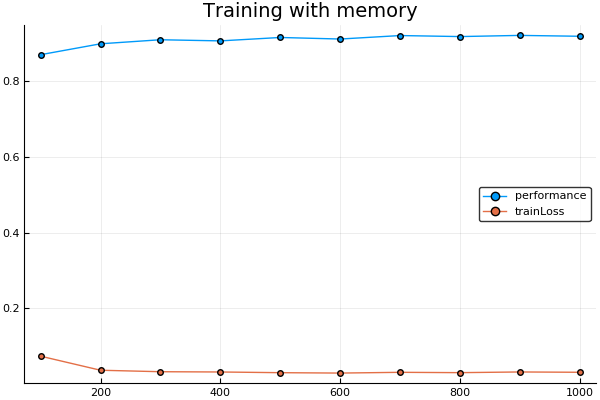

In [8]:
# Plot training

using Plots
pyplot()

plot(memHistory)
plot!(title = "Training with memory")

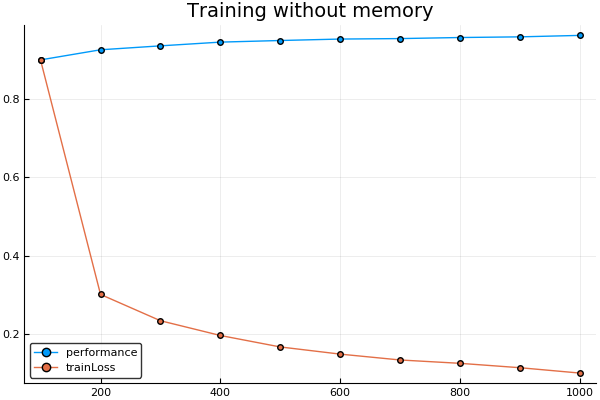

In [9]:
plot(classicHistory)
plot!(title = "Training without memory")